In [ ]:
import os
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "{ROOT}/MyDrive/data/kaggle"

/content/drive/MyDrive/data/kaggle


In [ ]:
!ls

kaggle.json


In [ ]:
from os.path import join
MY_GOOGLE_DRIVE_PATH = "MyDrive/Task/"

KAGGLE = ".kaggle"
KAGGLE_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH, KAGGLE)
os.environ['KAGGLE_CONFIG_DIR'] = KAGGLE_PATH
!pip install --upgrade --force-reinstall --no-deps kaggle
%cd "{KAGGLE_PATH}"

PROJECT = "Titanic"
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH, PROJECT)

!mkdir "{PROJECT_PATH}"
# print(PROJECT_PATH)


Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
/content/drive/.shortcut-targets-by-id/1srYR8TqwFsUSR4BYzQtIBmWUKrEBjd44/Task/.kaggle
mkdir: cannot create directory ‘/content/drive/MyDrive/Task/Titanic’: File exists


In [ ]:
%cd "{PROJECT_PATH}"

/content/drive/.shortcut-targets-by-id/1srYR8TqwFsUSR4BYzQtIBmWUKrEBjd44/Task/Titanic


In [ ]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 5.08MB/s]


In [ ]:
!unzip titanic.zip
!rm titanic.zip

Archive:  titanic.zip
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: gender_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!ls

gender_submission.csv  test.csv  train.csv


# Titanic

* Data : Kaggle(Titanic)_https://www.kaggle.com/c/titanic
* Duration : 7th.July.2021 18:00
* Target : Alive or Death

In [ ]:
import time
import random
import math
import itertools

import csv
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train = pd.read_csv(f"{PROJECT_PATH}/train.csv", encoding="UTF-8")
test = pd.read_csv(f"{PROJECT_PATH}/test.csv", encoding="UTF-8")
submission = pd.read_csv(f"{PROJECT_PATH}/gender_submission.csv", encoding="UTF-8")

## EDA & VSL

In [ ]:
train.shape

(891, 12)

In [ ]:
test.shape

(418, 11)

In [ ]:
submission.shape

(418, 2)

In [ ]:
target = train.loc[:, ['PassengerId', 'Survived']]
train = train.drop('Survived', axis=1)

trn_df = train.merge(target, how='left')
tst_df = test.merge(submission, how='left')

In [ ]:
tst_df.shape

(418, 12)

In [ ]:
trn_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [ ]:
trn_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208,0.383838
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429,0.486592
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


train과 test(test+samplesubmission)의 열 형태까지 동일하게 만듦

In [ ]:
trn_df.Pclass.dtype

dtype('int64')

In [ ]:
trn_df.Age.dtype

dtype('float64')

In [ ]:
trn_df.Name.dtype

dtype('O')

In [ ]:
object_col = []
numeric_col = []

for col in trn_df.columns:
  if (trn_df[col].dtype==int) or (trn_df[col].dtype==float):
    numeric_col.append(col)
  else:
    object_col.append(col)

In [ ]:
[col for col in object_col]

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [ ]:
[col for col in numeric_col]

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']

In [ ]:
category_col = []         # train
dbchk_category_col = []   # test category columns for comparing

for col in object_col:
  #train
  if len(trn_df[col].unique())<=10:
    category_col.append(col)
    print(f"\n\nUnique in trn_{col} :\n\t{trn_df[col].unique()}")
  elif len(trn_df[col].unique())>10:
    print(f"\n\nCounts of trn_{col}'s Unique :\n\t{len(trn_df[col].unique())}")
  print(f"\n\nZero Values in trn_{col} :\n\t{len([v for v in trn_df[col] if type(v)==float])}")
  #test
  if len(tst_df[col].unique())<=10:
    dbchk_category_col.append(col)
    print(f"\n\nUniques in tst_{col} :\n\t{tst_df[col].unique()}")
  elif len(tst_df[col].unique())>10:
    print(f"\n\nCounts of tst_{col}'s Unique :\n\t{len(tst_df[col].unique())}")
  print(f"\n\nZero Values in tst_{col} :\n\t{len([v for v in tst_df[col] if type(v)==float])}")



Counts of trn_Name's Unique :
	891


Zero Values in trn_Name :
	0


Counts of tst_Name's Unique :
	418


Zero Values in tst_Name :
	0


Unique in trn_Sex :
	['male' 'female']


Zero Values in trn_Sex :
	0


Uniques in tst_Sex :
	['male' 'female']


Zero Values in tst_Sex :
	0


Counts of trn_Ticket's Unique :
	681


Zero Values in trn_Ticket :
	0


Counts of tst_Ticket's Unique :
	363


Zero Values in tst_Ticket :
	0


Counts of trn_Cabin's Unique :
	148


Zero Values in trn_Cabin :
	687


Counts of tst_Cabin's Unique :
	77


Zero Values in tst_Cabin :
	327


Unique in trn_Embarked :
	['S' 'C' 'Q' nan]


Zero Values in trn_Embarked :
	2


Uniques in tst_Embarked :
	['Q' 'S' 'C']


Zero Values in tst_Embarked :
	0


In [ ]:
for col in numeric_col:
  if len(trn_df[col].unique())<=10:
    category_col.append(col)
    print(f"\n\nUnique in trn_{col} :\n\t{trn_df[col].unique()}")
  elif len(trn_df[col].unique())>10:
    print(f"\n\nRange of trn_{col} : \n\t{trn_df[col].min()}~{trn_df[col].max()}")
  
  if trn_df[col].isna().sum()==0:
    pass
  elif trn_df[col].isna().sum()!=0:
    print(f"\n\nNull Values in trn_{col} :\n\t{trn_df[col].isna().sum()}")

  if len(tst_df[col].unique())<=10:
    dbchk_category_col.append(col)
    print(f"\n\nUnique in tst_{col} :\n\t{tst_df[col].unique()}")
  elif len(tst_df[col].unique())>10:
    print(f"\n\nRange of tst_{col} : \n\t{tst_df[col].min()}~{tst_df[col].max()}")

  if tst_df[col].isna().sum()==0:
    pass
  elif tst_df[col].isna().sum()!=0:
    print(f"\n\nNull Values in tst_{col} :\n\t{tst_df[col].isna().sum()}")



Range of trn_PassengerId : 
	1~891


Range of tst_PassengerId : 
	892~1309


Unique in trn_Pclass :
	[3 1 2]


Unique in tst_Pclass :
	[3 2 1]


Range of trn_Age : 
	0.42~80.0


Null Values in trn_Age :
	177


Range of tst_Age : 
	0.17~76.0


Null Values in tst_Age :
	86


Unique in trn_SibSp :
	[1 0 3 4 2 5 8]


Unique in tst_SibSp :
	[0 1 2 3 4 5 8]


Unique in trn_Parch :
	[0 1 2 5 3 4 6]


Unique in tst_Parch :
	[0 1 3 2 4 6 5 9]


Range of trn_Fare : 
	0.0~512.3292


Range of tst_Fare : 
	0.0~512.3292


Null Values in tst_Fare :
	1


Unique in trn_Survived :
	[0 1]


Unique in tst_Survived :
	[0 1]


In [ ]:
trn_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64

In [ ]:
tst_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64

* Zero or Null
  * Train
    * Cabin(687)-Zero
    * Embarked(2)-Zero
    * Age(177)-Null
  * Test
    * Cabin(327)-Zero
    * Age(86)-Null
    * Fare(1)-Null
* Unique of Category_col
  * Sex-match
  * Embarked-match
  * SibSp-match
  * Parch-doesn't match
  * Survived-match

In [ ]:
category_col

['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch', 'Survived']

In [ ]:
dbchk_category_col

['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch', 'Survived']

In [ ]:
from IPython.display import display as dp
from IPython import display

### 가설1
정수가 아닌 형태로 들어가 있는 데이터를 정수화할 것인가?

**Age->YES**(물론 서양권에서는 0살부터 나이라고 생각하지만, 자기소개할 때 n살 m개월이라고 하는 얘기를 들어본 적이 없음. 한 달만 지나면 n살이야까지는 들었어도 몇 달 남았는지 굳이 말하지 않음)
  * ~~결측치는 mean으로 채울지, 75%로 채울지 고민하다가 75%로 채우기로 함~~실패
  * 75%로 넣으니까 쌍곡분포 형태로 만들어져서, median을 사용할 예정(확인 결과, 사용 가능함)

**Fare->No**(유로화인지 달러화인지 화폐 단위는 알 수 없지만, 둘 다 소수점 둘째자리까지 존재하는 화폐임, 또한 가족(혹은 단체)로 승선한 경우, 인원수(혹은 좌석수)에 따라 개인 비용으로 나눴는지, 합산한 비용인지 알 수 없음)
  * test에 존재하는 1개의 결측치는 mean으로 채움

In [ ]:
print("Train")
print(dp(trn_df.describe(include=float).T))

print("Test")
print(dp(tst_df.describe(include=float).T))

# tst_df.describe(include=[np.float]).T

Train


,count,mean,std,min,25%,50%,75%,max
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


None
Test


,count,mean,std,min,25%,50%,75%,max
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.0,76.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.5,512.3292


None


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056

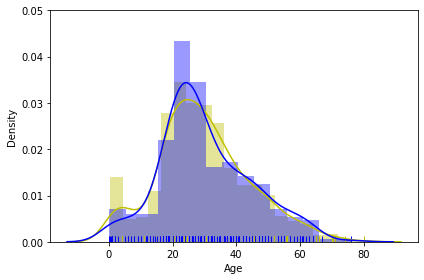

In [ ]:
sns.distplot(trn_df['Age'], color='y', rug=True)
sns.distplot(tst_df['Age'], color='b', rug=True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056

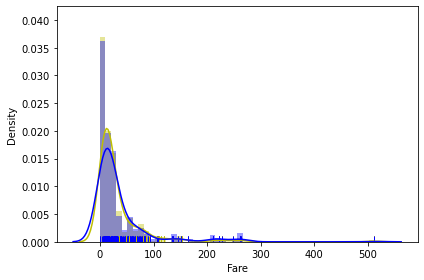

In [ ]:
sns.distplot(trn_df['Fare'], color='y', rug=True)
sns.distplot(tst_df['Fare'], color='b', rug=True)
plt.tight_layout()
plt.show()

In [ ]:
# trn_age_q75 = trn_df['Age'].quantile(0.75)
# trn_df['Age'] = trn_df['Age'].fillna(trn_age_q75)
# trn_df['Age'] = trn_df['Age'].astype('int')

# tst_age_q75 = tst_df['Age'].quantile(0.75)
# tst_df['Age'] = tst_df['Age'].fillna(tst_age_q75)
# tst_df['Age'] = tst_df['Age'].astype('int')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056

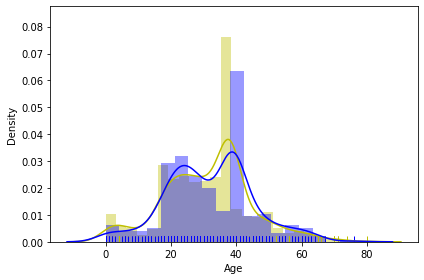

In [ ]:
# sns.distplot(trn_df['Age'], color='y', rug=True)
# sns.distplot(tst_df['Age'], color='b', rug=True)
# plt.tight_layout()
# plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056

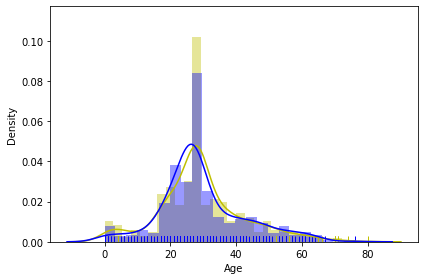

In [ ]:
trn_age_median = trn_df['Age'].median()
trn_df['Age'] = trn_df['Age'].fillna(trn_age_median)
trn_df['Age'] = trn_df['Age'].astype('int')

tst_age_median = tst_df['Age'].median()
tst_df['Age'] = tst_df['Age'].fillna(tst_age_median)
tst_df['Age'] = tst_df['Age'].astype('int')

sns.distplot(trn_df['Age'], color='y', rug=True)
sns.distplot(tst_df['Age'], color='b', rug=True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056

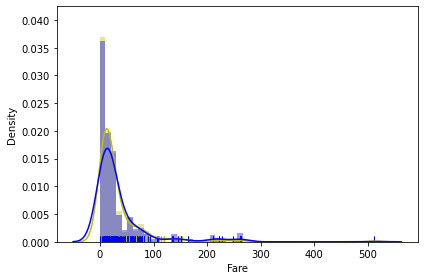

In [ ]:
trn_df['Fare'] = trn_df['Fare'].round(2)

tst_df['Fare'] = tst_df['Fare'].fillna(tst_df['Fare'].mean())
tst_df['Fare'] = tst_df['Fare'].round(2)

sns.distplot(trn_df['Fare'], color='y', rug=True)
sns.distplot(tst_df['Fare'], color='b', rug=True)
plt.tight_layout()
plt.show()

### 가설2

In [ ]:
print("Train")
print(dp(trn_df.describe(include=int).T))

print("Test")
print(dp(tst_df.describe(include=int).T))

Train


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.0,223.5,446.0,668.5,891.0
Pclass,891.0,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Age,891.0,29.345679,13.028212,0.0,22.0,28.0,35.0,80.0
SibSp,891.0,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Survived,891.0,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0


None
Test


,count,mean,std,min,25%,50%,75%,max
PassengerId,418.0,1100.500000,120.810458,892.0,996.25,1100.5,1204.75,1309.0
Pclass,418.0,2.265550,0.841838,1.0,1.00,3.0,3.00,3.0
Age,418.0,29.574163,12.721533,0.0,23.00,27.0,35.75,76.0
SibSp,418.0,0.447368,0.896760,0.0,0.00,0.0,1.00,8.0
Parch,418.0,0.392344,0.981429,0.0,0.00,0.0,0.00,9.0
Survived,418.0,0.363636,0.481622,0.0,0.00,0.0,1.00,1.0


None


In [ ]:
numeric_col

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056

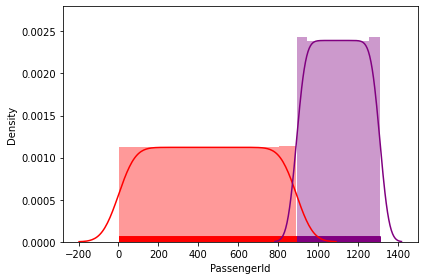

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

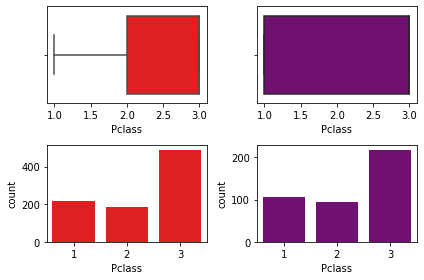

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

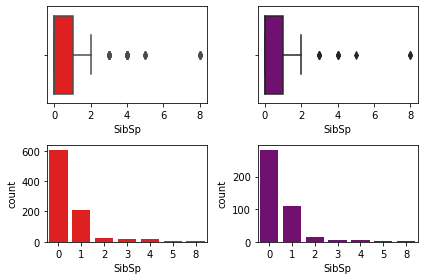

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

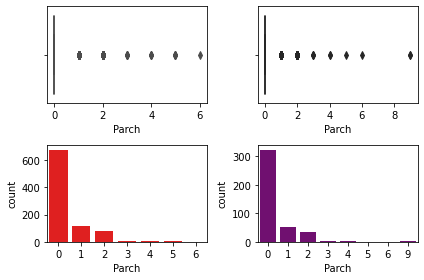

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

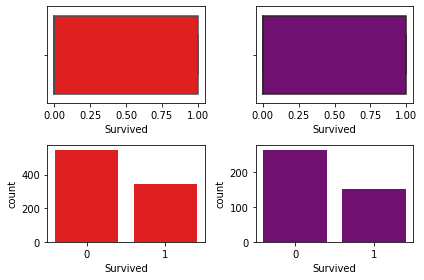

In [ ]:
for col in numeric_col:
  if (col!='Age') and (col!='Fare') and (col not in category_col):
    sns.distplot(trn_df[col], color='r', rug=True)
    sns.distplot(tst_df[col], color='purple', rug=True)
    plt.tight_layout()
    plt.show()
  elif col in category_col:
    f, ax = plt.subplots(nrows=2, ncols=2)
    sns.boxplot(trn_df[col], color='r', ax=ax[0, 0])
    sns.boxplot(tst_df[col], color='purple', ax=ax[0, 1])
    sns.countplot(trn_df[col], color='r', ax=ax[1, 0])
    sns.countplot(tst_df[col], color='purple', ax=ax[1, 1])
    plt.tight_layout()
    plt.show()

* Outlier
  * SibSp
    * q75*3 이상인 값에 대해 quantile(0.75)x2~3에서 랜덤하게 교체
  * Parch

In [ ]:
sibsp_random = random.randint(2,4)
# 형제가 4명인 것은 그럴 수 있음(문학 인용_작은아씨들의 자매 수 : 4명)
# 그렇지만 이상치 제거를 할 때, w를 보통 1.5~3을 주었기 때문에 우선 q75*3을 벗어나는 값에 대해서만 q75*2, q75*3을 랜덤하게 부여함

trn_sibsp_q75 = trn_df['SibSp'].quantile(0.75)  #1
# w = 4 -> outlier = 12
# w = 3 -> outlier = 30
# w = 2 -> outlier = 46
cnt = 0
for idx, v in enumerate(trn_df['SibSp']):
  if v>(trn_sibsp_q75*2):
    cnt+=1
    # print(idx, v)
print(cnt)

tst_sibsp_q75 = tst_df['SibSp'].quantile(0.75)  #1
# w = 4 -> outlier = 3
# w = 3 -> outlier = 7
# w = 2 -> outlier = 11
cnt = 0
for idx, v in enumerate(tst_df['SibSp']):
  if v>(tst_sibsp_q75*2):
    cnt+=1
    # print(idx, v)
print(cnt)

46
0


In [ ]:
trn_sibsp_otlr = [v for v in trn_df['SibSp'] if v>(trn_sibsp_q75*3)]
tst_sibsp_otlr = [v for v in tst_df['SibSp'] if v>(tst_sibsp_q75*3)]

for value in trn_sibsp_otlr:
  trn_df['SibSp'] = trn_df['SibSp'].replace(value, sibsp_random)
for value in tst_sibsp_otlr:
  tst_df['SibSp'] = tst_df['SibSp'].replace(value, sibsp_random)

In [ ]:
parch_random = random.randint(2,4)
trn_parch_q85 = trn_df['Parch'].quantile(0.85)  #1
print(trn_parch_q85)
# w = 4 -> outlier = 12
# w = 3 -> outlier = 10
# w = 2 -> outlier = 15
cnt = 0
for idx, v in enumerate(trn_df['Parch']):
  if v>(trn_parch_q85*4):
    cnt+=1
    # print(idx, v)
print(cnt)

tst_parch_q85 = tst_df['Parch'].quantile(0.85)  #1
print(tst_parch_q85)
# w = 4 -> outlier = 3
# w = 3 -> outlier = 6
# w = 2 -> outlier = 9
cnt = 0
for idx, v in enumerate(tst_df['Parch']):
  if v>(tst_parch_q85*4):
    cnt+=1
    # print(idx, v)
print(cnt)

1.0
6
1.0
4


In [ ]:
tst_sibsp_q25 = trn_df['SibSp'].quantile(0.25)
print(trn_sibsp_q25)
trn_sibsp_q50 = trn_df['SibSp'].quantile(0.5)
print(trn_sibsp_q50)
trn_sibsp_q75 = trn_df['SibSp'].quantile(0.75)
print(trn_sibsp_q75)
print(trn_sibsp_q75*1.5)
print(trn_sibsp_q75*2)
print(trn_sibsp_q75*2.5)
print(trn_sibsp_q75*3)

### 가설 3

In [ ]:
print("Train")
print(dp(trn_df.describe(include=object).T))

print("Test")
print(dp(tst_df.describe(include=object).T))

Train


,count,unique,top,freq
Name,891,891,"Mullens, Miss. Katherine ""Katie""",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,G6,4
Embarked,889,3,S,644


None
Test


,count,unique,top,freq
Name,418,418,"Asplund, Mr. Carl Oscar Vilhelm Gustafsson",1
Sex,418,2,male,266
Ticket,418,363,PC 17608,5
Cabin,91,76,B57 B59 B63 B66,3
Embarked,418,3,S,270


None


In [ ]:
for col in object_col:
  if (col!='Age') and (col!='Fare') and (col not in category_col):
    sns.catplot(trn_df[col], color='r', rug=True)
    sns.catplot(tst_df[col], color='purple', rug=True)
    plt.tight_layout()
    plt.show()
  elif col in category_col:
    f, ax = plt.subplots(nrows=2, ncols=2)
    sns.boxplot(trn_df[col], color='r', ax=ax[0, 0])
    sns.boxplot(tst_df[col], color='purple', ax=ax[0, 1])
    sns.countplot(trn_df[col], color='r', ax=ax[1, 0])
    sns.countplot(tst_df[col], color='purple', ax=ax[1, 1])
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


TypeError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056

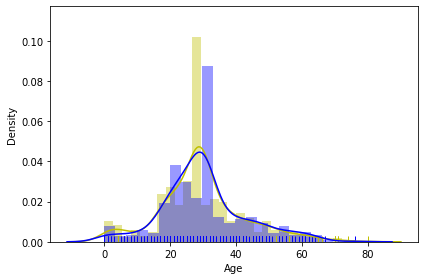

In [ ]:
check_trn = trn_df.copy()
check_tst = tst_df.copy()

# trn_age_q75 = check_trn['Age'].median()
# check_trn['Age'] = check_trn['Age'].fillna(trn_age_q75)
check_trn['Fare'] = check_trn['Fare'].round(2)
# tst_age_q75 = check_tst['Age'].median()
check_tst['Fare'] = check_tst['Fare'].fillna(check_tst['Fare'].mean())
check_tst['Fare'] = check_tst['Fare'].round(2)

sns.distplot(check_trn['Fare'], color='y', rug=True)
sns.distplot(check_tst['Fare'], color='b', rug=True)
plt.tight_layout()
plt.show()


check_trn2 = trn_df.copy()
check_tst2 = tst_df.copy()

trn_age_q75 = check_trn2['Age'].mean()
check_trn2['Age'] = check_trn2['Age'].fillna(trn_age_q75)
check_trn2['Age'] = check_trn2['Age'].astype('int')

tst_age_q75 = check_tst2['Age'].mean()
check_tst2['Age'] = check_tst2['Age'].fillna(tst_age_q75)
check_tst2['Age'] = check_tst2['Age'].astype('int')

sns.distplot(check_trn2['Age'], color='y', rug=True)
sns.distplot(check_tst2['Age'], color='b', rug=True)
plt.tight_layout()
plt.show()

* Missing Values
  * Train
    * Cabin(687)-Zero
    * Embarked(2)-Zero
    * ~~Age(177)-Null~~
  * Test
    * Cabin(327)-Zero
    * ~~Age(86)-Null~~
    * ~~Fare(1)-Null~~

In [ ]:
trn_df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Mullens, Miss. Katherine ""Katie""",male,347082,G6,S
freq,1,577,7,4,644


In [ ]:
sns.kdeplot(x=trn_df['Age'], hue=trn_df['Survived'], y=trn_df['Parch'], hue_order={1:"Alive", 0:"Death"}, palette='Pastel1')

## MODEL(DL)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.preprocessing import sequence